In [26]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_image(path, target_size=(224, 224)):
    img = cv2.imread(path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

def preprocess_image(img):
    img = np.expand_dims(img, axis=0)
    return img


In [27]:
# Load and preprocess the images
img1 = load_image("/content/heartimage1.PNG")
img2 = load_image("/content/heartimage2.PNG")
img3 = load_image("/content/heartimage3.PNG")

In [28]:
# Preprocess the images for the model
preprocessed_img1 = preprocess_image(img1)
preprocessed_img2 = preprocess_image(img2)
preprocessed_img3 = preprocess_image(img3)

In [29]:
# Load the pre-trained ResNet model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

102967424/102967424 [==============================] - 1s 0us/step


In [30]:
# Get the class prediction for each image
pred1 = model.predict(preprocessed_img1)
pred2 = model.predict(preprocessed_img2)
pred3 = model.predict(preprocessed_img3)


1/1 [==============================] - 0s 206ms/step


In [31]:
# Get the top predicted class index for each image
class_index1 = np.argmax(pred1)
class_index2 = np.argmax(pred2)
class_index3 = np.argmax(pred3)

In [32]:
# Get the output tensor of the last convolutional layer and the gradient tensor
last_conv_layer = model.get_layer('conv5_block3_out')
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('conv5_block3_out').output, model.output])


In [33]:
# Compute the gradients of the predicted class with respect to the output feature map of the last conv layer
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(preprocessed_img1)
    loss = predictions[:, class_index1]

grads = tape.gradient(loss, conv_outputs)[0]

In [34]:
# Compute the guided gradients
guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads


In [35]:
# Get the weights of the guided gradients
weights = tf.reduce_mean(guided_grads, axis=(0, 1))

In [38]:
cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
for i, w in enumerate(weights):
    w_expanded = tf.expand_dims(tf.expand_dims(w, 0), 0)  # Expand dimensions to match conv_outputs
    cam += tf.reduce_sum(w_expanded * conv_outputs[:, :, i], axis=-1)

# Normalize the CAM
cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())


In [39]:
# Superimpose the CAM on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(np.uint8(img1 * 255), 0.5, heatmap, 0.5, 0)

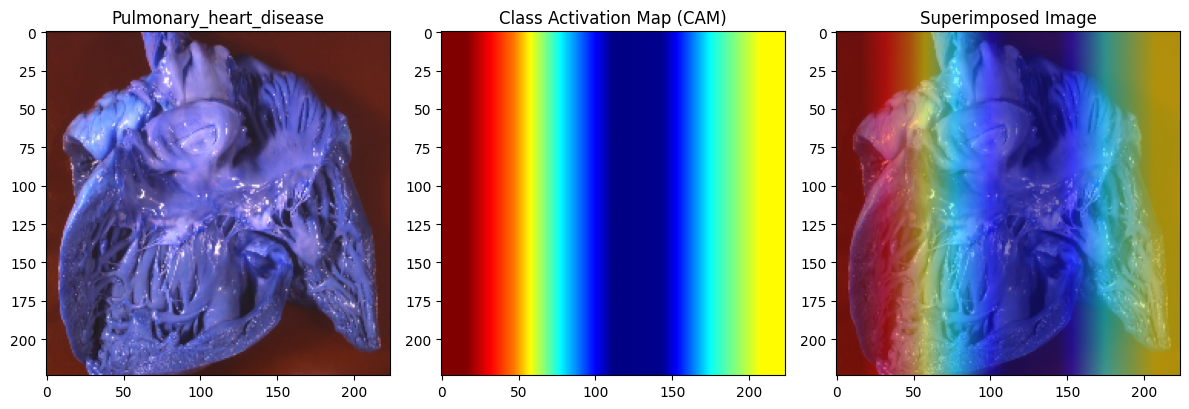

In [47]:
# Display the original image, CAM, and superimposed image
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(img1)
plt.title('Pulmonary_heart_disease')

plt.subplot(132)
plt.imshow(heatmap)
plt.title('Class Activation Map (CAM)')

plt.subplot(133)
plt.imshow(superimposed_img)
plt.title('Superimposed Image')

plt.tight_layout()
plt.show()

In [44]:
# Compute CAM for each image
def compute_cam(preprocessed_img, class_index):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_img)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        w_expanded = tf.expand_dims(tf.expand_dims(w, 0), 0)  # Expand dimensions to match conv_outputs
        cam += tf.reduce_sum(w_expanded * conv_outputs[:, :, i], axis=-1)

    # Normalize the CAM
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    return heatmap

heatmap2 = compute_cam(preprocessed_img2, class_index2)
heatmap3 = compute_cam(preprocessed_img3, class_index3)



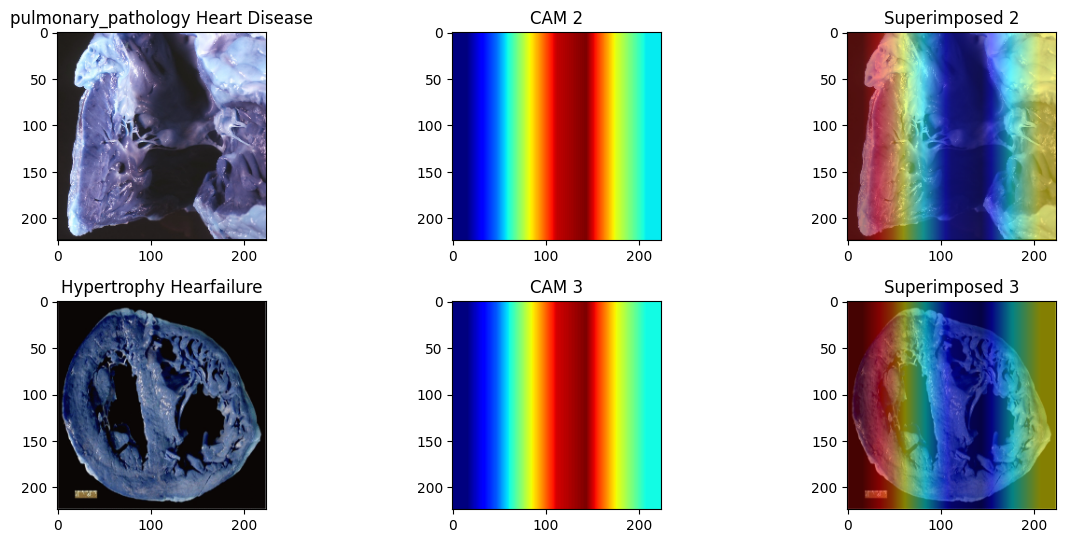

In [48]:
# Superimpose CAM on the original images
superimposed_img2 = cv2.addWeighted(np.uint8(img2 * 255), 0.5, cv2.applyColorMap(np.uint8(255 * heatmap2), cv2.COLORMAP_JET), 0.5, 0)
superimposed_img3 = cv2.addWeighted(np.uint8(img3 * 255), 0.5, cv2.applyColorMap(np.uint8(255 * heatmap3), cv2.COLORMAP_JET), 0.5, 0)

# Display the images with CAMs superimposed
plt.figure(figsize=(12, 8))

plt.subplot(334)
plt.imshow(img2)
plt.title('pulmonary_pathology Heart Disease')

plt.subplot(335)
plt.imshow(heatmap2, cmap='jet')
plt.title('CAM 2')

plt.subplot(336)
plt.imshow(superimposed_img2)
plt.title('Superimposed 2')

plt.subplot(337)
plt.imshow(img3)
plt.title('Hypertrophy Hearfailure')

plt.subplot(338)
plt.imshow(heatmap3, cmap='jet')
plt.title('CAM 3')

plt.subplot(339)
plt.imshow(superimposed_img3)
plt.title('Superimposed 3')

plt.tight_layout()
plt.show()
